In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim

from torchvision import datasets, transforms
import tqdm
from torchvision.utils import make_grid

import torch.distributions as tdist

import numpy as np
import tqdm

import matplotlib.pyplot as plt

In [0]:
BATCH_SIZE = 100
EPOCHS = 100
VISIBLE_SIZE = 784
HIDDEN_SIZE = 100

In [0]:
def visualize_RBM_weights(weights, grid_width, grid_height, slice_shape=(28, 28)):
    for idx in range(0, grid_width * grid_height):
        plt.subplot(grid_height, grid_width, idx+1)
        plt.imshow(weights[..., idx].reshape(slice_shape))
        plt.axis('off')

def sigmoid(x, gpu=True):
    if gpu:
      return 1 / (1 + torch.exp(-x))
    else:
      return 1 / (1 + np.exp(-x))
    

def draw_rec(inp, title, size, Nrows, in_a_row, j):
    plt.subplot(Nrows, in_a_row, j)
    plt.imshow(inp.reshape(size), vmin=0, vmax=1, interpolation="nearest")
    plt.title(title)
    plt.axis('off')
    
    
def reconstruct(ind, states, orig, weights, biases, h1_shape=(10, 10), v_shape=(28,28)):
    j = 1
    in_a_row = 6
    Nimg = states.shape[1] + 3
    Nrows = int(np.ceil(float(Nimg+2)/in_a_row))
    
    plt.figure(figsize=(12, 2*Nrows))
       
    draw_rec(states[ind], 'states', h1_shape, Nrows, in_a_row, j)
    j += 1
    draw_rec(orig[ind], 'input', v_shape, Nrows, in_a_row, j)
    
    reconstr = biases.copy()
    j += 1
    draw_rec(sigmoid(reconstr, False), 'biases', v_shape, Nrows, in_a_row, j)
    
    for i in range(h1_shape[0] * h1_shape[1]):
        if states[ind,i] > 0:
            j += 1
            reconstr = reconstr + weights[:,i]
            titl = '+= s' + str(i+1)
            draw_rec(sigmoid(reconstr, False), titl, v_shape, Nrows, in_a_row, j)
    plt.tight_layout()

In [0]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor()
                               ])), batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor()
                               ])), batch_size=BATCH_SIZE)

In [0]:
class RBM():
    
    def __init__(self, visible_size, hidden_size, cd_k=1):
        self.v_size = visible_size
        self.h_size = hidden_size
        self.cd_k = cd_k
        
        normal_dist = tdist.Normal(0, 0.1)
        
        self.W = torch.Tensor(normal_dist.sample(sample_shape=(self.v_size, self.h_size))).cuda()
        self.v_bias = torch.Tensor(torch.zeros(self.v_size)).cuda()
        self.h_bias = torch.Tensor(torch.zeros(self.h_size)).cuda()


    def __call__(self, batch):
        return self.forward(batch)

    
    def forward(self, batch):
        return self._cd_pass(batch)
    
    
    def _cd_pass(self, batch):
        batch = batch.view(-1, 784)
        v0 = torch.bernoulli(batch)
        h0_prob = sigmoid(torch.matmul(v0, self.W) + self.h_bias)
        h0 = torch.bernoulli(h0_prob)

        h1 = h0

        for step in range(0, self.cd_k):
            v1_prob = sigmoid(torch.matmul(h1, self.W.T) + self.v_bias)
            v1 = torch.bernoulli(v1_prob)
            h1_prob = sigmoid(torch.matmul(v1, self.W) + self.h_bias)
            h1 = torch.bernoulli(h1_prob)
            
        return h0_prob, h0, h1_prob, h1, v1_prob, v1
    
    def reconstruct(self, h, gibbs_steps=None):
        h1 = h
        
        steps_to_do = self.cd_k
        if gibbs_steps is not None:
            steps_to_do = gibbs_steps

        for step in range(0, steps_to_do):
            v1_prob = sigmoid(torch.matmul(h1, self.W.T) + self.v_bias)
            v1 = torch.bernoulli(v1_prob)
            h1_prob = sigmoid(torch.matmul(v1, self.W) + self.h_bias)
            h1 = torch.bernoulli(h1_prob)

        return h1_prob, h1, v1_prob, v1

    
    def update_weights_for_batch(self, batch, learning_rate=0.01):
        h0_prob, h0, h1_prob, h1, v1_prob, v1 = self._cd_pass(batch)
        v0 = torch.bernoulli(batch)

        w_positive_grad = torch.matmul(v0.T, h0)
        w_negative_grad = torch.matmul(v1.T, h1)

        dw = (w_positive_grad - w_negative_grad) / batch.shape[0]

        self.W = self.W + learning_rate * dw
        self.v_bias = self.v_bias + learning_rate*torch.mean(v0-v1, dim=0)
        self.h_bias = self.h_bias + learning_rate*torch.mean(h0-h1, dim=0)

In [0]:
class DBN():

    def __init__(self, first_rbm: RBM, second_hidden_size, cd_k=1):
        self.v_size = first_rbm.v_size
        self.h1_size = first_rbm.h_size
        self.h2_size = second_hidden_size
        self.cd_k = cd_k
        
        normal_dist = tdist.Normal(0, 0.1)
        
        self.W1 = first_rbm.W.cuda()
        self.v_bias = first_rbm.v_bias.clone().cuda()
        self.h1_bias = first_rbm.h_bias.clone().cuda()
        
        self.W2 = torch.Tensor(normal_dist.sample(sample_shape=(self.h1_size, self.h2_size))).cuda()
        self.h2_bias = torch.Tensor(torch.zeros(self.h2_size)).cuda()
    
    
    def forward(self, batch, steps=None):
        batch = batch.view(-1, 784)
        # v = torch.bernoulli(batch)
        h1up_prob = sigmoid(torch.matmul(batch, self.W1) + self.h1_bias)
        h1up = torch.bernoulli(h1up_prob)
        
        h2up_prob = sigmoid(torch.matmul(h1up, self.W2) + self.h2_bias)
        h2up = torch.bernoulli(h2up_prob)
        
        h1down_prob, h1down, h2down_prob, h2down = self.gibbs_sampling(h2up, steps)
        
        return h1up_prob, h1up, h2up_prob, h2up, h1down_prob, h1down, h2down_prob, h2down

    
    def gibbs_sampling(self, h2, steps=None):
        h2down = h2
        
        steps_to_do = self.cd_k
        
        if steps is not None:
            steps_to_do = steps

        for step in range(0, steps_to_do):
            h1down_prob = sigmoid(torch.matmul(h2down, self.W2.T) + self.h1_bias)
            h1down = torch.bernoulli(h1down_prob)
            
            h2down_prob = sigmoid(torch.matmul(h1down, self.W2) + self.h2_bias)
            h2down = torch.bernoulli(h2down_prob)
            
        return h1down_prob, h1down, h2down_prob, h2down 
    
    def reconstruct(self, h2, steps=None):
        _, _, h2down_prob, h2down = self.gibbs_sampling(h2, steps)
        
        h1down_prob = sigmoid(torch.matmul(h2down, self.W2.T) + self.h1_bias)
        h1down = torch.bernoulli(h1down_prob)
        
        v_prob = sigmoid(torch.matmul(h1down, self.W1.T) + self.v_bias)
        v_out = torch.bernoulli(v_prob)
        
        return v_prob, v_out, h2down_prob, h2down
    
    def update_weights_for_batch(self, batch, learning_rate=0.01):
        h1up_prob, h1up, h2up_prob, h2up, h1down_prob, h1down, h2down_prob, h2down = self.forward(batch)

        w2_positive_grad = h2up * (h1up - h1down_prob)
        w2_negative_grad = h1down * (h2down - h2down_prob)

        dw2 = (w2_positive_grad - w2_negative_grad) / h1up.shape[0]

        self.W2 = self.W2 + learning_rate * dw2
        self.h1_bias = self.h1_bias + learning_rate*torch.mean(h1up - h1down, dim=0)
        self.h2_bias = self.h2_bias + learning_rate*torch.mean(h2up - h2down, dim=0)
        
                
    
    def __call__(self, batch):
        return self.forward(batch)

In [15]:
model = RBM(visible_size=VISIBLE_SIZE, hidden_size=HIDDEN_SIZE, cd_k=1)

for curr_epoch in tqdm.tqdm(range(0, EPOCHS)):
    for sample, label in train_loader:
        sample = sample.cuda()
        label = label.cuda()
        sample = sample.view(-1, 784)
        model.update_weights_for_batch(sample, 0.1)

100%|██████████| 100/100 [11:09<00:00,  6.70s/it]


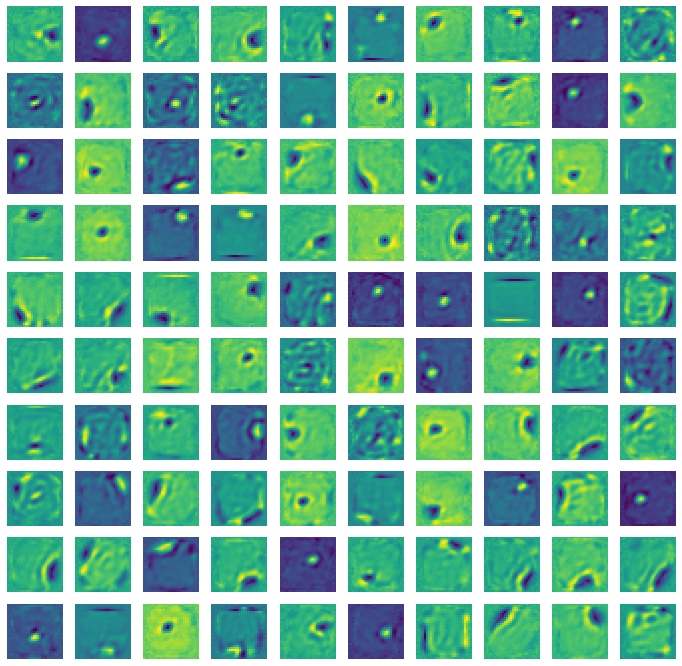

In [16]:
plt.figure(figsize=(12, 12), facecolor='w')
visualize_RBM_weights(model.W.data.cpu(), 10, 10)

In [20]:
dbnmodel = DBN(model, second_hidden_size=100, cd_k=2)
for curr_epoch in tqdm.tqdm(range(0, EPOCHS)):
    for sample, label in train_loader:
        sample = sample.cuda()
        label = label.cuda()
        sample = sample.view(-1, 784)
        dbnmodel.update_weights_for_batch(sample)

100%|██████████| 100/100 [11:42<00:00,  7.02s/it]


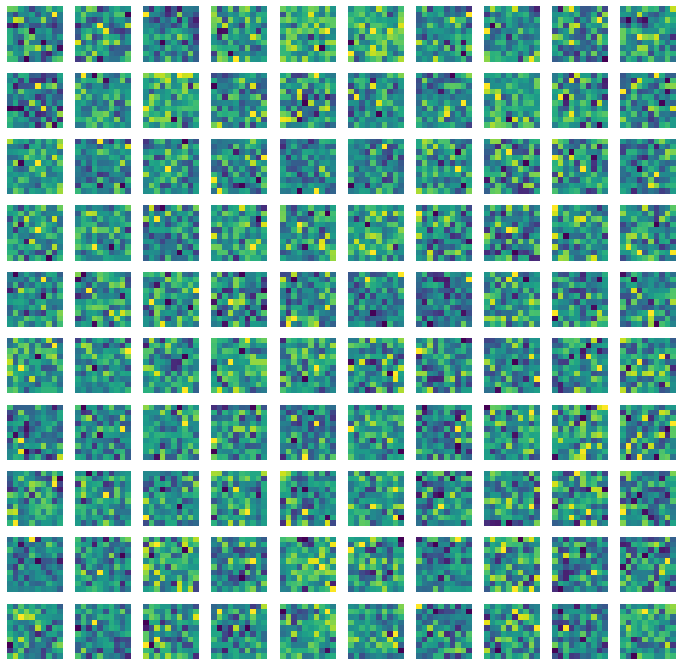

In [21]:
plt.figure(figsize=(12, 12), facecolor='w')
visualize_RBM_weights(dbnmodel.W2.data.cpu(), 10, 10, slice_shape=(10, 10))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


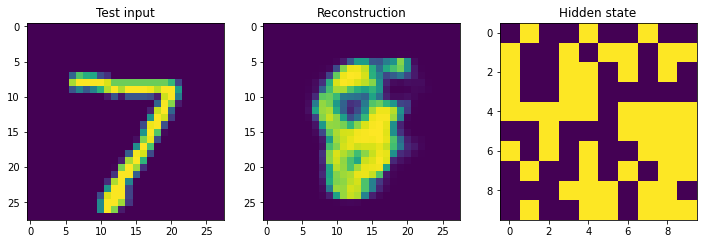

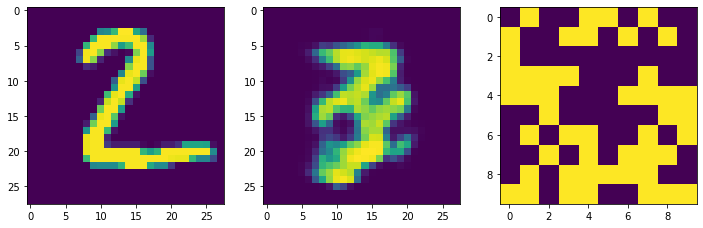

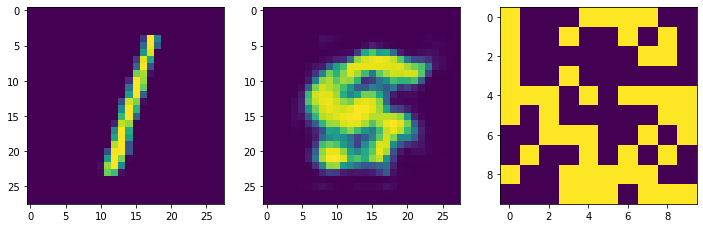

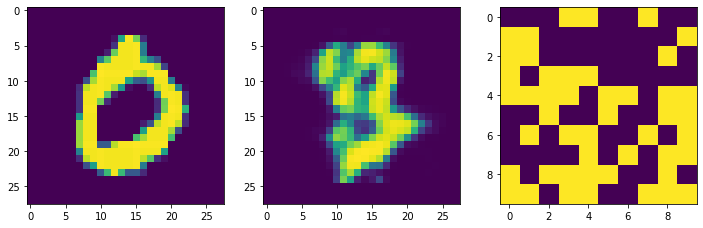

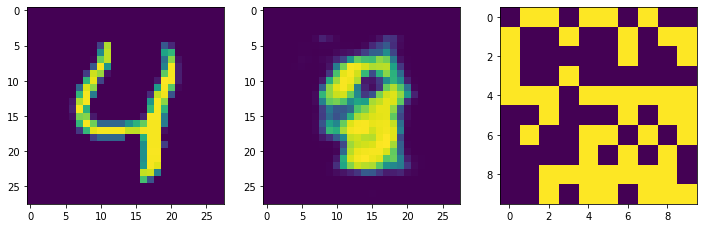

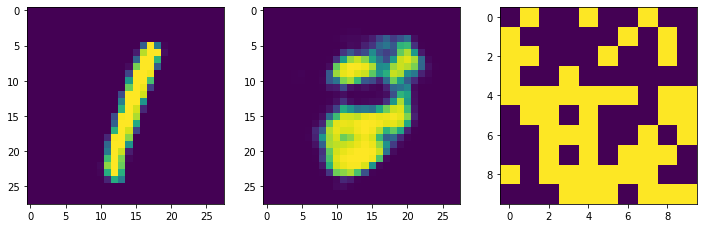

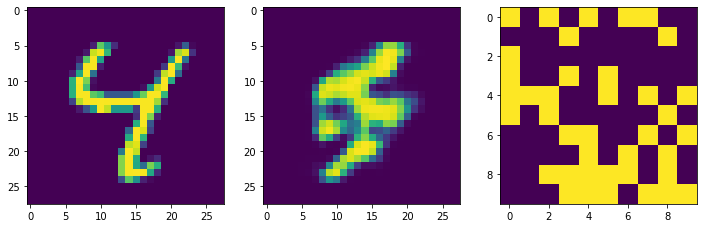

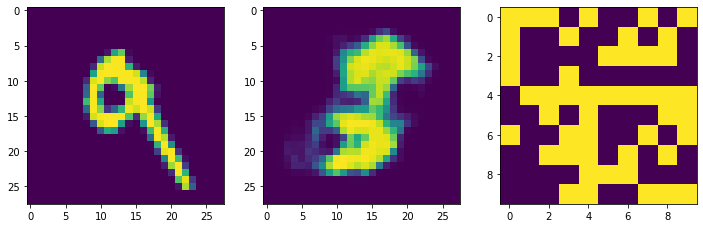

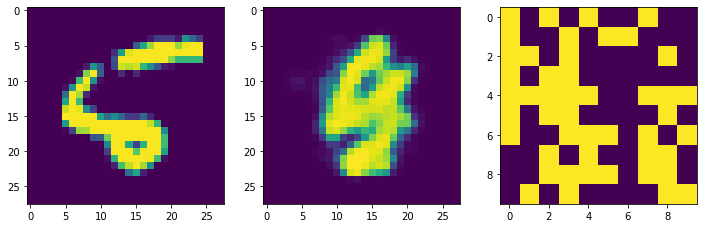

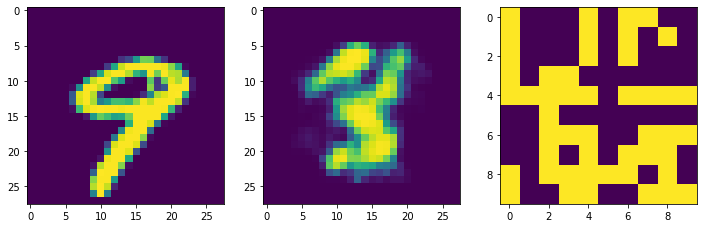

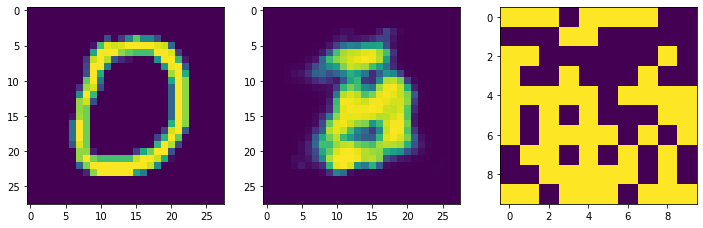

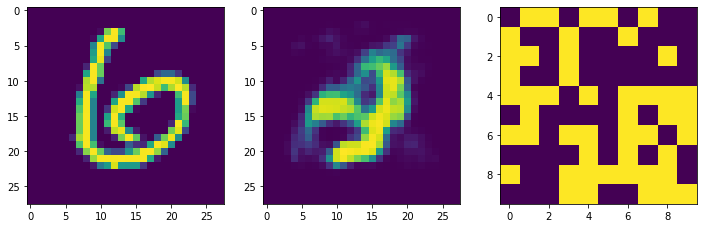

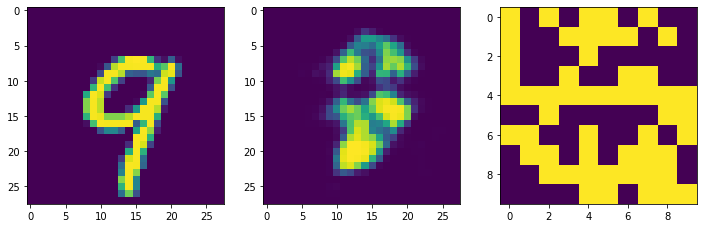

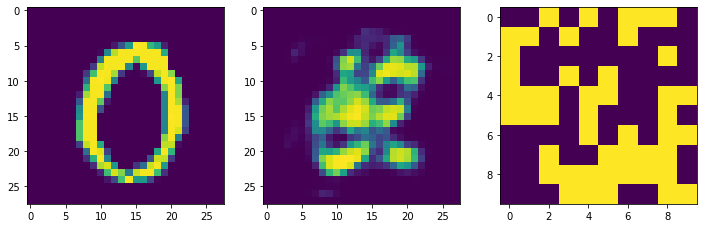

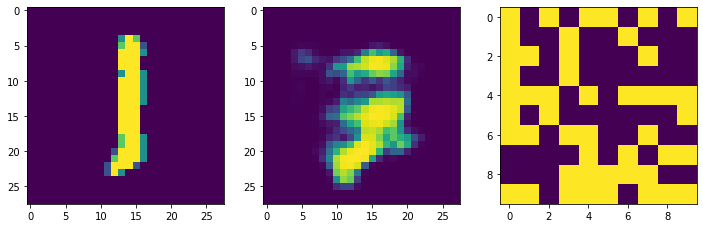

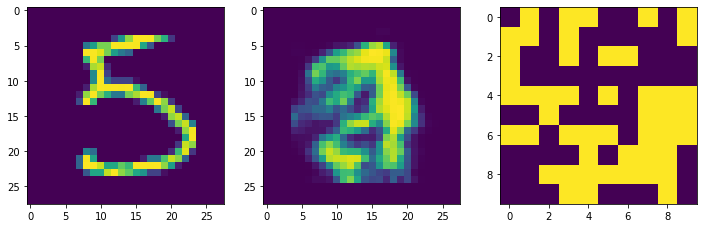

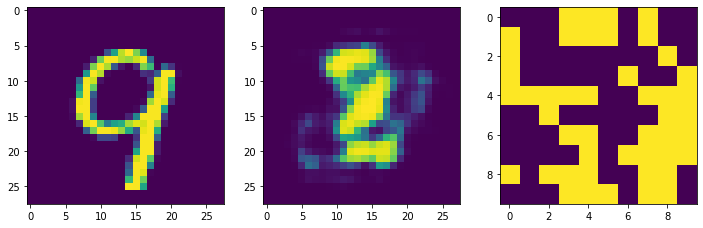

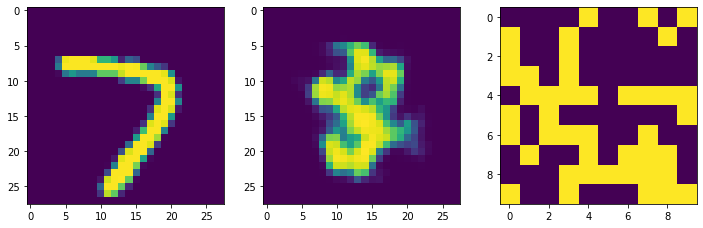

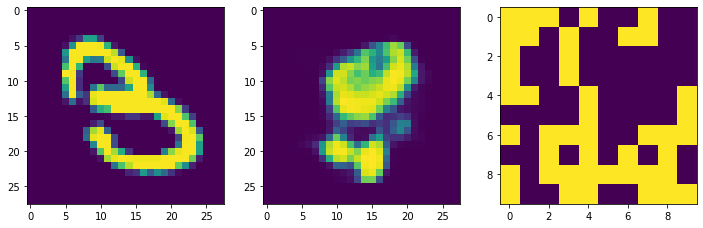

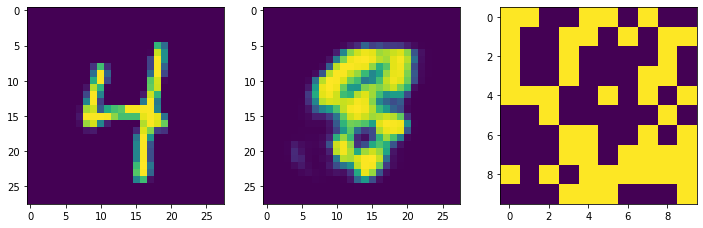

<Figure size 1152x1152 with 0 Axes>

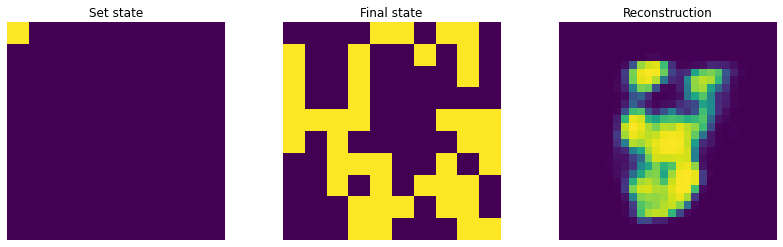

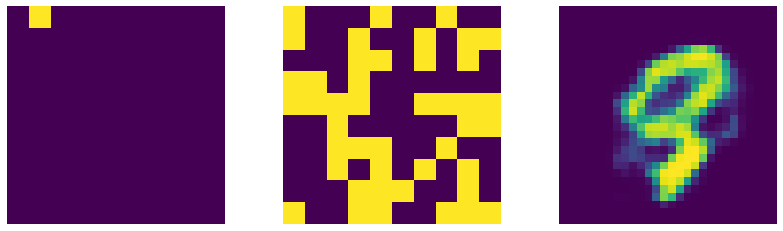

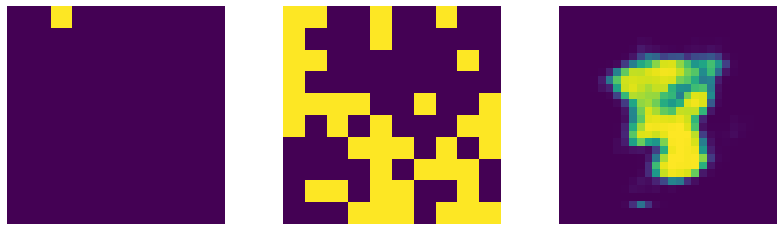

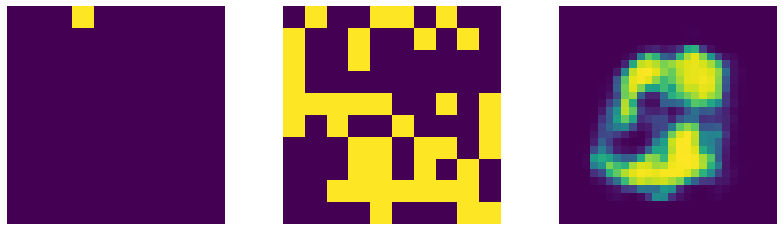

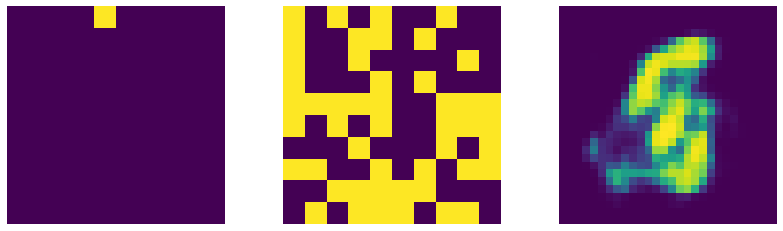

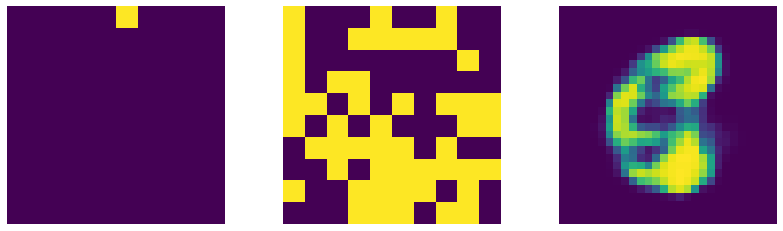

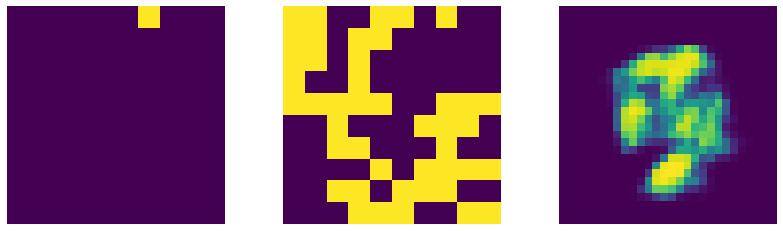

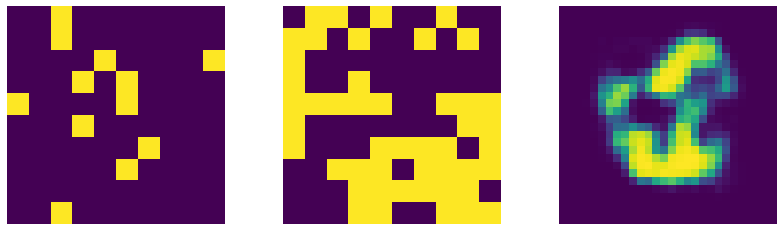

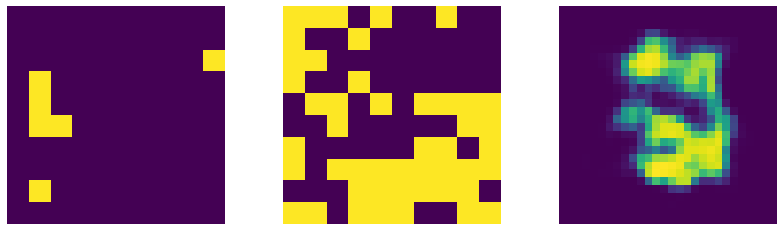

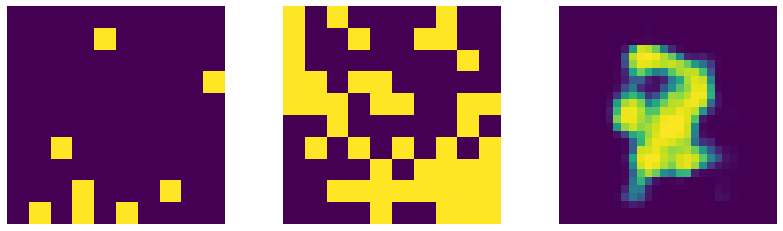

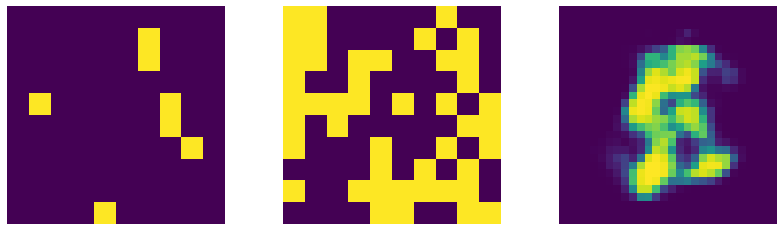

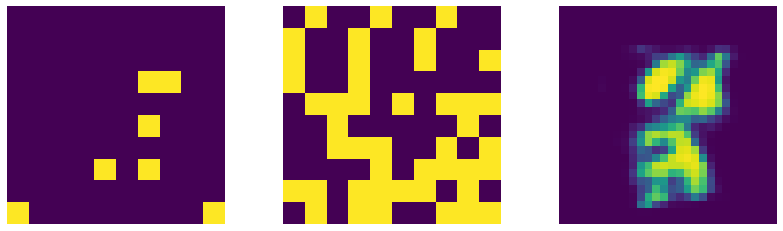

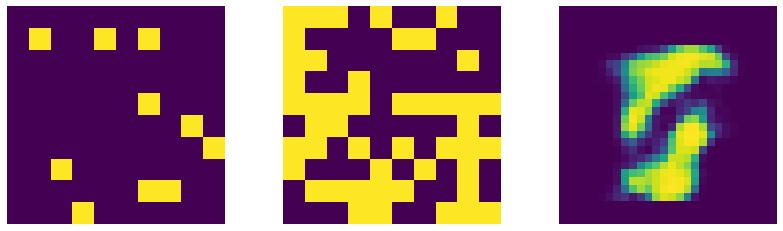

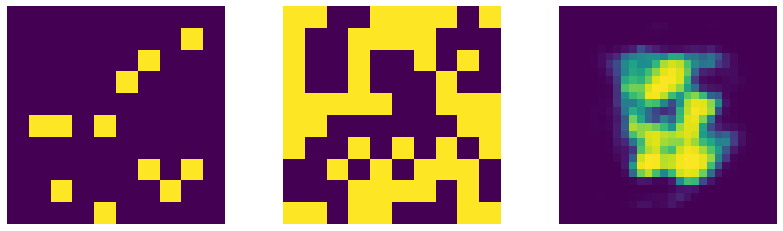

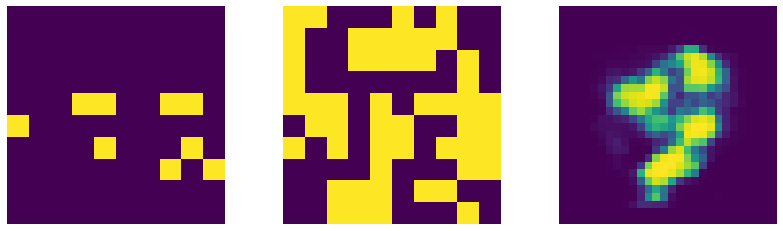

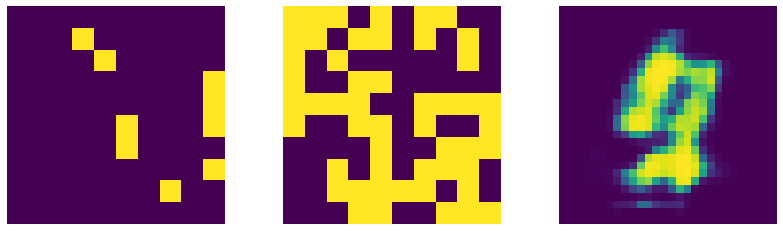

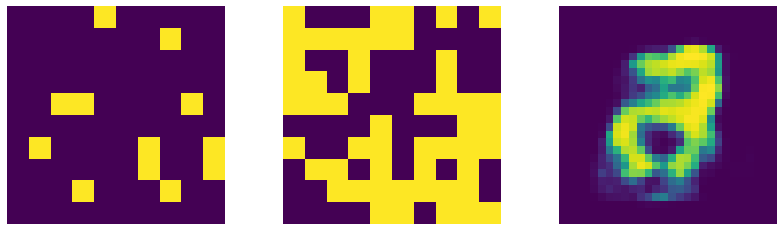

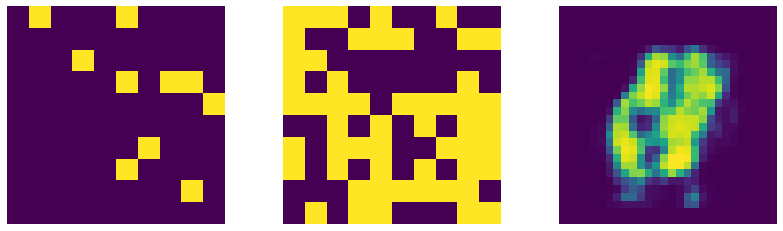

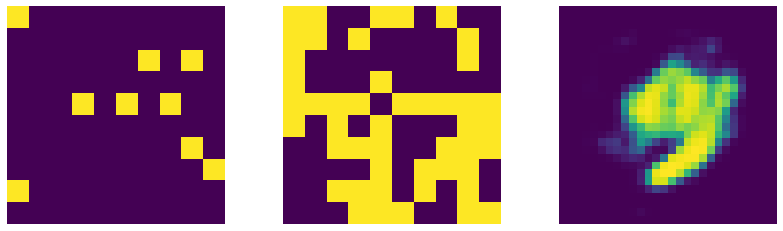

In [28]:
sample, _ = next(iter(test_loader))
sample = sample.view(-1, 784)

for idx in range(0, 20):
    h1up_prob, h1up, h2up_prob, h2up, h1down_prob, h1down, h2down_prob, h2down = dbnmodel(sample[idx, ...].cuda())
    v_prob, v, _, _ = dbnmodel.reconstruct(h2down)

    plt.figure(figsize=(4*3, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(sample[idx,...].view(28, 28))
    if idx == 0:
        plt.title("Test input")
    
    plt.subplot(1, 3, 2)
    plt.imshow(v_prob[0, ...].cpu().view(28, 28))
    if idx == 0:
        plt.title("Reconstruction")
    
    plt.subplot(1, 3, 3)
    plt.imshow(h2down.cpu().view(10, 10))
    if idx == 0:
        plt.title("Hidden state")


r_input = np.random.rand(100, HIDDEN_SIZE)
r_input[r_input > 0.9] = 1 # postotak aktivnih - slobodno varirajte
r_input[r_input < 1] = 0
r_input = r_input * 20 # pojačanje za slučaj ako je mali postotak aktivnih

s = 10
i = 0
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s

v_out_prob, v_out, h2down_prob, h2down = dbnmodel.reconstruct(torch.from_numpy(r_input).cuda().float(), 100)

plt.figure(figsize=(16, 16))
for idx in range(0, 19):
    plt.figure(figsize=(14, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(r_input[idx, ...].reshape(10, 10))
    if idx == 0:
        plt.title("Set state")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(h2down[idx, ...].cpu().view(10, 10))
    if idx == 0:
        plt.title("Final state")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(v_out_prob[idx, ...].cpu().view(28, 28))
    if idx == 0:
        plt.title("Reconstruction")
    plt.axis('off')